In [1]:
from pydoc import describe

from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
# Variables
# Paramètres de connexion MySQL
db_url = "jdbc:mysql://mysql-container:3306/wildlens?serverTimezone=UTC"
db_properties = { "user": "root",
                  "password": "root",
                  "driver": "com.mysql.cj.jdbc.Driver" }
mysql_driver_path = os.path.abspath("installation/mysql-connector-j-9.1.0.zip")

In [3]:
# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", "mysql_driver_path") \
    .getOrCreate()

print("✅ Spark initialisé avec le driver MySQL :", mysql_driver_path)
print(spark.sparkContext.getConf().get("spark.jars"))


25/03/10 21:43:17 WARN Utils: Your hostname, DESKTOP-V5T7J8A resolves to a loopback address: 127.0.1.1; using 172.25.127.84 instead (on interface eth0)
25/03/10 21:43:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/10 21:43:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/10 21:43:19 WARN DependencyUtils: Local jar /mnt/c/Users/HP/PycharmProjects/ETL/mysql_driver_path does not exist, skipping.
25/03/10 21:43:19 INFO SparkContext: Running Spark version 3.5.4
25/03/10 21:43:19 INFO SparkContext: OS info Linux, 5.15.133.1-microsoft-standard-WSL2, amd64
25/03/10 21:43:19 INFO SparkContext: Java version 11.0.26
25/03/10 21:43:19 INFO ResourceUtils: ==============================================================
25/03/10 21:43:19 INFO ResourceUtils: No custom resources configured for spark.driver.
25/03/10 21:43:19 INFO ResourceUtils: ============================================

✅ Spark initialisé avec le driver MySQL : /mnt/c/Users/HP/PycharmProjects/ETL/installation/mysql-connector-j-9.1.0.zip
mysql_driver_path


In [4]:
try:
    # 📌 Tentative de lecture des tables MySQL
    df_tables = spark.read.jdbc(url=db_url, table="information_schema.tables", properties=db_properties)

    # 📌 Affichage des tables disponibles dans la base `wildlens`
    df_tables.filter(df_tables["TABLE_SCHEMA"] == "wildlens").select("TABLE_NAME").show()

    print("✅ Connexion à MySQL réussie et tables listées avec succès !")

except Exception as e:
    print(f"❌ Erreur de connexion à MySQL : {e}")

25/03/10 21:43:21 INFO SharedState: Setting hive.metastore.warehouse.dir ('null') to the value of spark.sql.warehouse.dir.
25/03/10 21:43:21 INFO SharedState: Warehouse path is 'file:/mnt/c/Users/HP/PycharmProjects/ETL/spark-warehouse'.


❌ Erreur de connexion à MySQL : An error occurred while calling o64.jdbc.
: java.lang.ClassNotFoundException: com.mysql.cj.jdbc.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:594)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:527)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:103)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:41)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRela

# Gestion des métadonnées des espèces

 Dans un premier temps, nous scannons les dossiers disponibles afin d'en faire un dataframe et réutiliser ces informations.
 Puis nous récupérons les métadonnées depuis l'API Mistral grâce à un prompt optimisé (optimisation du grounding, du prompt engineering)
 un sleep de 3s a été ajouté afin d'éviter de trop spam l'API
 -- transféré dans un fichier à part --

In [5]:
folder_all_animals = [d for d in os.listdir("ressource/image/train") if os.path.isdir(os.path.join("ressource/image/train", d))]
df_all_animals = pd.DataFrame(folder_all_animals, columns=["Nom du dossier"])

# Gestion des images
Dans un premier temps, nous allons faire une première analyse des images: leurs nombre par espèces (donc, par dossier), leurs tailles moyenne, leurs poid moyen, etc...

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne
0,beaver,96,271.531250,279.572917
1,black_bear,186,447.930108,421.924731
2,bob_cat,171,250.976608,258.438596
3,coyote,123,359.276423,405.422764
4,elephant,32,652.687500,580.812500
5,goose,141,329.971631,311.737589
6,gray_fox,126,278.182540,283.531746
7,horse,71,383.521127,340.492958
8,lion,95,370.610526,385.273684
9,mink,139,302.273381,293.719424


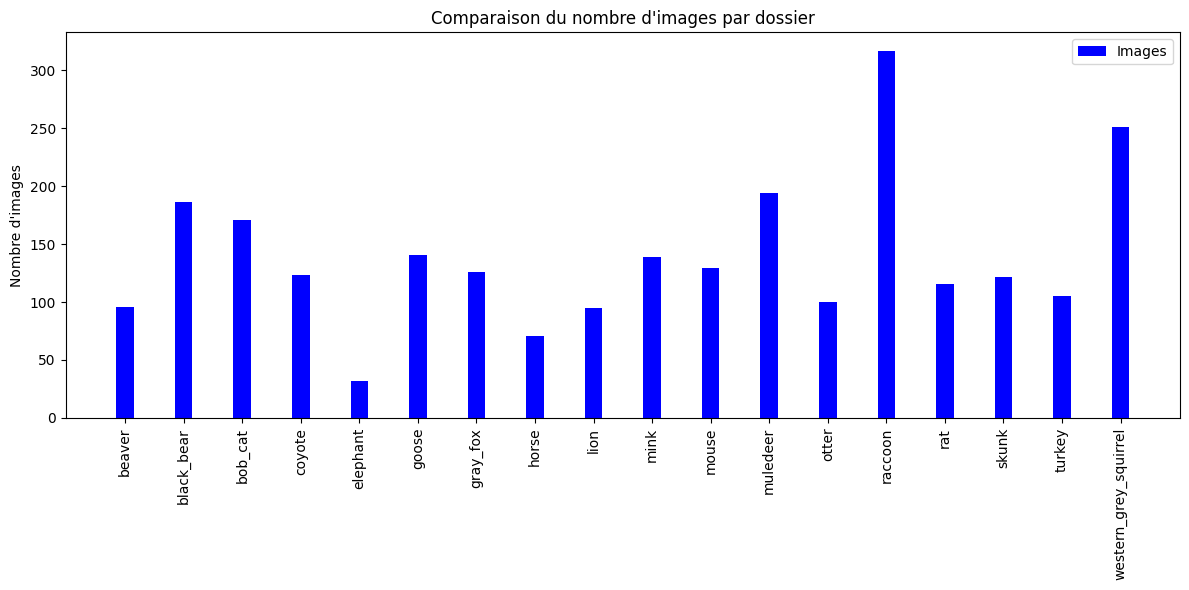

In [6]:
# Définition des chemins des datasets
image = "ressource/image/train"
# Fonction pour récupérer les infos des images d'un dossier (en gérant les dossiers absents)
def get_image_info(folder_path):
    if not os.path.exists(folder_path):  # 📌 Vérifie si le dossier existe
        return 0, None, None  # ⚠️ Si absent → 0 images et tailles nulles

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    num_images = len(image_files)

    if num_images == 0:
        return num_images, None, None  # Aucun fichier image

    widths, heights = [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_width = sum(widths) / len(widths) if widths else None
    avg_height = sum(heights) / len(heights) if heights else None

    return num_images, avg_width, avg_height

# Listes pour stocker les infos
image_data = []

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(image, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
df_image = pd.DataFrame(image_data, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Affichage du DataFrame de comparaison
display(df_image)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = df_image["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, df_image["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()



# Augmentation des images
## Data Augmentation et Transformation des Données
La Data Augmentation est une technique utilisée en apprentissage automatique, notamment en vision par ordinateur et en traitement du langage naturel (NLP), pour augmenter la diversité des données d'entraînement sans collecter de nouvelles données. Elle permet de rendre les modèles plus robustes et d'améliorer leur généralisation.

- Calculer la Mediane du nombre des images
- Determiner le Q3 afin que le nombre d'image finale de chaque animale se rapproche
- Calculer le coefficient de multiplication pour chaque classe d'animaux
- Modifier et sauvegarder les nouvelles images
-

In [7]:
# 📂 Définition du chemin des images
image = "ressource/image/train"
augmented_image_folder = "ressource/image/augmented_train"

# 📝 Étape 1 : Calculer la médiane et Q3 du nombre d'images
median_images = df_image["Nombre d'images"].median()
q3_images = df_image["Nombre d'images"].quantile(0.75)

print(f"Médiane: {median_images}, Q3: {q3_images}")


Médiane: 124.5, Q3: 163.5


In [8]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import albumentations as A

# Création du dossier de sortie s'il n'existe pas
os.makedirs(augmented_image_folder, exist_ok=True)

# Détermination du coefficient de Data Augmentation
df_image["Coeff"] = np.ceil(q3_images / df_image["Nombre d'images"])

# Définition des transformations
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.GaussNoise(p=0.1),
    A.Resize(256, 256)
])

# Boucle sur chaque classe d’animaux
for index, row in df_image.iterrows():
    if row["Coeff"] < 4 :
        folder_name = row["Nom du dossier"]
        coeff = int(row["Coeff"])

        original_folder = os.path.join(image, folder_name)
        augmented_folder = os.path.join(augmented_image_folder, folder_name)
        os.makedirs(augmented_folder, exist_ok=True)

        image_files = [f for f in os.listdir(original_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

        for img_file in image_files:
            img_path = os.path.join(original_folder, img_file)
            img = cv2.imread(img_path)  # Lecture avec OpenCV (BGR)

            if img is None:
                print(f"❌ Erreur de lecture de l'image {img_file}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Conversion en RGB (évite les problèmes de couleur)

            for i in range(coeff):  # Générer plusieurs images augmentées
                augmented = augmentation(image=img)["image"]
                new_img_path = os.path.join(augmented_folder, f"aug_{i}_{img_file}")
                cv2.imwrite(new_img_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))  # Sauvegarde avec OpenCV

print("✅ Data Augmentation terminée avec succès !")


/home/jason/.virtualenvs/ETL/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


✅ Data Augmentation terminée avec succès !


,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne,Coeff
0,beaver,192,256.0,256.0,2.0
1,black_bear,186,256.0,256.0,1.0
2,bob_cat,171,256.0,256.0,1.0
3,coyote,246,256.0,256.0,2.0
4,elephant,0,NaN,NaN,6.0
5,goose,282,256.0,256.0,2.0
6,gray_fox,252,256.0,256.0,2.0
7,horse,213,256.0,256.0,3.0
8,lion,190,256.0,256.0,2.0
9,mink,278,256.0,256.0,2.0


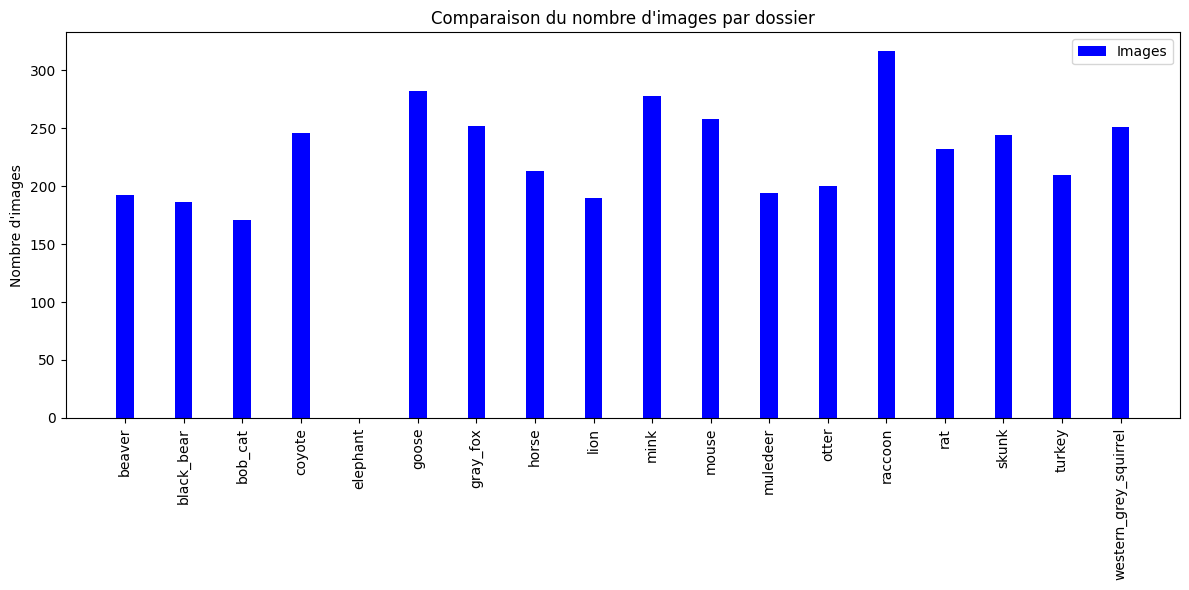

In [9]:
# Listes pour stocker les infos
image_data_new = []
image_new = "ressource/image/augmented_train"

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(image_new, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data_new.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
image_data_new = pd.DataFrame(image_data_new, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
image_data_new["Coeff"] = df_image["Coeff"]
# Affichage du DataFrame de comparaison
display(image_data_new)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = image_data_new["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, image_data_new["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
display(image_data_new)

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne,Coeff
0,beaver,192,256.0,256.0,2.0
1,black_bear,186,256.0,256.0,1.0
2,bob_cat,171,256.0,256.0,1.0
3,coyote,246,256.0,256.0,2.0
4,elephant,0,NaN,NaN,6.0
5,goose,282,256.0,256.0,2.0
6,gray_fox,252,256.0,256.0,2.0
7,horse,213,256.0,256.0,3.0
8,lion,190,256.0,256.0,2.0
9,mink,278,256.0,256.0,2.0


## Labélisation
Le dataframe d'images et les métadata sont fusionnées afin que chaque image corresponde à des métadonnées : c'est la labélisation.

In [11]:
df_metadata = pd.read_csv("./ressource/metadata.csv")

df_merged = pd.merge(image_data_new, df_metadata, left_on='Nom du dossier', right_on='Espèce anglais', how='left')
df_merged = df_merged.drop(columns=["Nom du dossier", "Largeur Moyenne", "Hauteur Moyenne"])
print(df_merged)
df_merged.to_csv("./ressource/data_merged.csv", header=True)

if print(df_merged['Espèce anglais'].isna().sum()):
    print("Toutes les lignes ont trouvés une correspondance")
display(df_merged)

    Nombre d'images  Coeff         Espèce anglais           Espèce français  \
0               192    2.0                 beaver                    Castor   
1               186    1.0             black_bear                 Ours noir   
2               171    1.0                bob_cat           Chat domestique   
3               246    2.0                 coyote                    Coyote   
4                 0    6.0               elephant                  éléphant   
5               282    2.0                  goose                       oie   
6               252    2.0               gray_fox               Renard gris   
7               213    3.0                  horse                    cheval   
8               190    2.0                   lion                      lion   
9               278    2.0                   mink            Vison d'Europe   
10              258    2.0                  mouse                    souris   
11              194    1.0               muledeer   

,Nombre d'images,Coeff,Espèce anglais,Espèce français,Famille,Nom latin,Description,Population estimée,Localisation
0,192,2.0,beaver,Castor,Castoridae,Castor fiber,Le castor est un rongeur semi-aquatique connu ...,1000000,France Canada Russie
1,186,1.0,black_bear,Ours noir,Ursidae,Ursus americanus,L'ours noir est un ours de taille moyenne avec...,900000,Canada États-Unis Mexique
2,171,1.0,bob_cat,Chat domestique,Felidae,Felis catus,Petit félin domestique au pelage court et aux ...,600000000,France États-Unis Royaume-Uni
3,246,2.0,coyote,Coyote,Canidae,Canis latrans,"Le coyote est un canidé de taille moyenne, ave...",3000000,États-Unis Canada Mexique
4,0,6.0,elephant,éléphant,Proboscidés,Loxodonta africana,L'éléphant d'Afrique est un grand mammifère he...,415000,Afrique du Sud Botswana Zimbabwe Kenya Tanzanie
5,282,2.0,goose,oie,Anatidae,Anser anser,L'oie est un grand oiseau aquatique avec un co...,2500000,Canada États-Unis Russie
6,252,2.0,gray_fox,Renard gris,Canidae,Urocyon cinereoargenteus,Le renard gris est un petit canidé aux poils g...,4000000,États-Unis Mexique Canada
7,213,3.0,horse,cheval,Equidae,Equus ferus caballus,"Mammifère quadrupède au corps robuste, au cou ...",58000000,France États-Unis Russie Chine
8,190,2.0,lion,lion,Felidae,Panthera leo,Le lion est un grand félin d'Afrique et d'Asie...,230000,"Afrique, Inde"
9,278,2.0,mink,Vison d'Europe,Mustelidae,Neogale vison,Petit mammifère semi-aquatique avec un pelage ...,1000000,"France, Allemagne, Pologne, Russie"


# State
Ajout d'un state aléatoire sur chaque image.

70% de train (1)

15% de test (2)

15% de val (3)

Ceci servira prochainement pour l'entrainement du model de machine learning


In [15]:
from pyspark.sql.functions import rand, when, col

df_merged_spark = spark.createDataFrame(df_merged)
image_new = "ressource/image/augmented_train"

df_dict = {}
for dossier in df_merged_spark.select("Espèce anglais").distinct().rdd.flatMap(lambda x: x).collect():
    folder_path = os.path.join(image_new, dossier)
    if os.path.exists(folder_path):
        df_images = spark.createDataFrame([(dossier, os.path.join(dossier, img)) for img in os.listdir(folder_path)],
                                          ["Espèce anglais", "Chemin Relatif"])
        df_dict[dossier] = df_images.join(df_merged_spark.select("Espèce anglais"), on="Espèce anglais")

train_ratio = 0.7
val_ratio = 0.15

for dossier, df in df_dict.items():

    df = df.withColumn("rand_val", rand())

    df = df.withColumn(
        "state",
        when(col("rand_val") <= train_ratio, 1)
        .when(col("rand_val") <= (train_ratio + val_ratio), 2)
        .otherwise(3)
    )

    df_dict[dossier] = df

    df.write.mode("overwrite").parquet(f"ressource/dataframes_parquet/{dossier}")
    df.write.mode("overwrite").csv(f"ressource/dataframes_csv/{dossier}")

    print(f"✅ State ajouté et fichier enregistré pour {dossier}")

25/03/10 21:52:29 INFO DAGScheduler: Registering RDD 60 (javaToPython at NativeMethodAccessorImpl.java:0) as input to shuffle 3
25/03/10 21:52:29 INFO DAGScheduler: Got map stage job 6 (javaToPython at NativeMethodAccessorImpl.java:0) with 8 output partitions
25/03/10 21:52:29 INFO DAGScheduler: Final stage: ShuffleMapStage 9 (javaToPython at NativeMethodAccessorImpl.java:0)
25/03/10 21:52:29 INFO DAGScheduler: Parents of final stage: List()
25/03/10 21:52:29 INFO DAGScheduler: Missing parents: List()
25/03/10 21:52:29 INFO DAGScheduler: Submitting ShuffleMapStage 9 (MapPartitionsRDD[60] at javaToPython at NativeMethodAccessorImpl.java:0), which has no missing parents
25/03/10 21:52:29 INFO MemoryStore: Block broadcast_6 stored as values in memory (estimated size 27.9 KiB, free 434.2 MiB)
25/03/10 21:52:29 INFO MemoryStore: Block broadcast_6_piece0 stored as bytes in memory (estimated size 13.0 KiB, free 434.2 MiB)
25/03/10 21:52:29 INFO BlockManagerInfo: Added broadcast_6_piece0 in me

✅ State ajouté et fichier enregistré pour black_bear


25/03/10 21:52:36 INFO DAGScheduler: Submitting 8 missing tasks from ShuffleMapStage 23 (MapPartitionsRDD[177] at parquet at NativeMethodAccessorImpl.java:0) (first 15 tasks are for partitions Vector(0, 1, 2, 3, 4, 5, 6, 7))
25/03/10 21:52:36 INFO TaskSchedulerImpl: Adding task set 23.0 with 8 tasks resource profile 0
25/03/10 21:52:36 INFO PythonRunner: Times: total = 127, boot = -1066, init = 1187, finish = 6
25/03/10 21:52:36 INFO Executor: Finished task 1.0 in stage 22.0 (TID 71). 2394 bytes result sent to driver
25/03/10 21:52:36 INFO TaskSetManager: Starting task 0.0 in stage 23.0 (TID 78) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:52:36 INFO TaskSetManager: Finished task 1.0 in stage 22.0 (TID 71) in 157 ms on 172.25.127.84 (executor driver) (1/8)
25/03/10 21:52:36 INFO Executor: Running task 0.0 in stage 23.0 (TID 78)
25/03/10 21:52:36 INFO PythonRunner: Times: total = 137, boot = -969, init = 1106, finish = 0
25/03/10 21:52:36 INFO Ex

✅ State ajouté et fichier enregistré pour beaver


25/03/10 21:52:39 INFO PythonRunner: Times: total = 128, boot = -984, init = 1112, finish = 0
25/03/10 21:52:39 INFO Executor: Finished task 2.0 in stage 32.0 (TID 106). 2394 bytes result sent to driver
25/03/10 21:52:39 INFO TaskSetManager: Starting task 0.0 in stage 33.0 (TID 112) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:52:39 INFO PythonRunner: Times: total = 124, boot = -856, init = 980, finish = 0
25/03/10 21:52:39 INFO PythonRunner: Times: total = 132, boot = -841, init = 973, finish = 0
25/03/10 21:52:39 INFO Executor: Running task 0.0 in stage 33.0 (TID 112)
25/03/10 21:52:39 INFO TaskSetManager: Finished task 2.0 in stage 32.0 (TID 106) in 151 ms on 172.25.127.84 (executor driver) (1/8)
25/03/10 21:52:39 INFO PythonRunner: Times: total = 132, boot = -979, init = 1111, finish = 0
25/03/10 21:52:39 INFO Executor: Finished task 1.0 in stage 32.0 (TID 105). 2394 bytes result sent to driver
25/03/10 21:52:39 INFO PythonRunner: Times: tot

✅ State ajouté et fichier enregistré pour bob_cat


25/03/10 21:52:41 INFO PythonRunner: Times: total = 137, boot = -1014, init = 1151, finish = 0
25/03/10 21:52:41 INFO PythonRunner: Times: total = 163, boot = -958, init = 1121, finish = 0
25/03/10 21:52:41 INFO PythonRunner: Times: total = 167, boot = -904, init = 1070, finish = 1
25/03/10 21:52:41 INFO PythonRunner: Times: total = 165, boot = -959, init = 1124, finish = 0
25/03/10 21:52:41 INFO Executor: Finished task 4.0 in stage 42.0 (TID 142). 2394 bytes result sent to driver
25/03/10 21:52:41 INFO TaskSetManager: Starting task 0.0 in stage 43.0 (TID 146) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:52:41 INFO Executor: Running task 0.0 in stage 43.0 (TID 146)
25/03/10 21:52:41 INFO Executor: Finished task 2.0 in stage 42.0 (TID 140). 2480 bytes result sent to driver
25/03/10 21:52:41 INFO Executor: Finished task 0.0 in stage 42.0 (TID 138). 2437 bytes result sent to driver
25/03/10 21:52:41 INFO TaskSetManager: Starting task 1.0 in stage 4

✅ State ajouté et fichier enregistré pour coyote


25/03/10 21:52:44 INFO PythonRunner: Times: total = 122, boot = -871, init = 993, finish = 0
25/03/10 21:52:44 INFO PythonRunner: Times: total = 130, boot = -1010, init = 1140, finish = 0
25/03/10 21:52:44 INFO Executor: Finished task 5.0 in stage 52.0 (TID 177). 2394 bytes result sent to driver
25/03/10 21:52:44 INFO TaskSetManager: Starting task 0.0 in stage 53.0 (TID 180) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:52:44 INFO Executor: Running task 0.0 in stage 53.0 (TID 180)
25/03/10 21:52:44 INFO TaskSetManager: Finished task 5.0 in stage 52.0 (TID 177) in 146 ms on 172.25.127.84 (executor driver) (1/8)
25/03/10 21:52:44 INFO Executor: Finished task 7.0 in stage 52.0 (TID 179). 2394 bytes result sent to driver
25/03/10 21:52:44 INFO TaskSetManager: Starting task 1.0 in stage 53.0 (TID 181) (172.25.127.84, executor driver, partition 1, PROCESS_LOCAL, 9346 bytes) 
25/03/10 21:52:44 INFO TaskSetManager: Finished task 7.0 in stage 52.0 (TID 17

✅ State ajouté et fichier enregistré pour goose


25/03/10 21:52:48 INFO PythonRunner: Times: total = 136, boot = -1023, init = 1159, finish = 0
25/03/10 21:52:48 INFO PythonRunner: Times: total = 157, boot = -989, init = 1146, finish = 0
25/03/10 21:52:48 INFO Executor: Finished task 0.0 in stage 62.0 (TID 206). 2394 bytes result sent to driver
25/03/10 21:52:48 INFO TaskSetManager: Starting task 0.0 in stage 63.0 (TID 214) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:52:48 INFO TaskSetManager: Finished task 0.0 in stage 62.0 (TID 206) in 183 ms on 172.25.127.84 (executor driver) (1/8)
25/03/10 21:52:48 INFO Executor: Running task 0.0 in stage 63.0 (TID 214)
25/03/10 21:52:48 INFO PythonRunner: Times: total = 174, boot = -1022, init = 1196, finish = 0
25/03/10 21:52:48 INFO Executor: Finished task 6.0 in stage 62.0 (TID 212). 2437 bytes result sent to driver
25/03/10 21:52:48 INFO Executor: Finished task 5.0 in stage 62.0 (TID 211). 2394 bytes result sent to driver
25/03/10 21:52:48 INFO TaskS

✅ State ajouté et fichier enregistré pour horse


25/03/10 21:52:51 INFO PythonRunner: Times: total = 112, boot = -816, init = 928, finish = 0
25/03/10 21:52:51 INFO BlockManagerInfo: Removed broadcast_42_piece0 on 172.25.127.84:33169 in memory (size: 8.3 KiB, free: 434.4 MiB)
25/03/10 21:52:51 INFO PythonRunner: Times: total = 110, boot = -925, init = 1035, finish = 0
25/03/10 21:52:51 INFO Executor: Finished task 0.0 in stage 72.0 (TID 240). 2394 bytes result sent to driver
25/03/10 21:52:51 INFO TaskSetManager: Starting task 0.0 in stage 73.0 (TID 248) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:52:51 INFO TaskSetManager: Finished task 0.0 in stage 72.0 (TID 240) in 136 ms on 172.25.127.84 (executor driver) (1/8)
25/03/10 21:52:51 INFO Executor: Running task 0.0 in stage 73.0 (TID 248)
25/03/10 21:52:51 INFO PythonRunner: Times: total = 129, boot = -849, init = 978, finish = 0
25/03/10 21:52:51 INFO Executor: Finished task 1.0 in stage 72.0 (TID 241). 2394 bytes result sent to driver
25/03/

✅ State ajouté et fichier enregistré pour gray_fox


25/03/10 21:52:54 INFO PythonRunner: Times: total = 184, boot = -846, init = 1030, finish = 0
25/03/10 21:52:54 INFO Executor: Finished task 4.0 in stage 82.0 (TID 278). 2394 bytes result sent to driver
25/03/10 21:52:54 INFO TaskSetManager: Starting task 0.0 in stage 83.0 (TID 282) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:52:54 INFO TaskSetManager: Finished task 4.0 in stage 82.0 (TID 278) in 199 ms on 172.25.127.84 (executor driver) (1/8)
25/03/10 21:52:54 INFO Executor: Running task 0.0 in stage 83.0 (TID 282)
25/03/10 21:52:54 INFO PythonRunner: Times: total = 209, boot = -871, init = 1080, finish = 0
25/03/10 21:52:54 INFO Executor: Finished task 3.0 in stage 82.0 (TID 277). 2394 bytes result sent to driver
25/03/10 21:52:54 INFO TaskSetManager: Starting task 1.0 in stage 83.0 (TID 283) (172.25.127.84, executor driver, partition 1, PROCESS_LOCAL, 9346 bytes) 
25/03/10 21:52:54 INFO TaskSetManager: Finished task 3.0 in stage 82.0 (TID 27

✅ State ajouté et fichier enregistré pour lion


25/03/10 21:52:59 INFO Executor: Finished task 2.0 in stage 92.0 (TID 310). 2480 bytes result sent to driver
25/03/10 21:52:59 INFO TaskSetManager: Starting task 0.0 in stage 93.0 (TID 316) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:52:59 INFO TaskSetManager: Finished task 2.0 in stage 92.0 (TID 310) in 171 ms on 172.25.127.84 (executor driver) (1/8)
25/03/10 21:52:59 INFO Executor: Running task 0.0 in stage 93.0 (TID 316)
25/03/10 21:52:59 INFO PythonRunner: Times: total = 117, boot = -736, init = 853, finish = 0
25/03/10 21:52:59 INFO PythonRunner: Times: total = 189, boot = -739, init = 928, finish = 0
25/03/10 21:52:59 INFO Executor: Finished task 0.0 in stage 92.0 (TID 308). 2437 bytes result sent to driver
25/03/10 21:52:59 INFO PythonRunner: Times: total = 182, boot = -715, init = 897, finish = 0
25/03/10 21:52:59 INFO TaskSetManager: Starting task 1.0 in stage 93.0 (TID 317) (172.25.127.84, executor driver, partition 1, PROCESS_LOCAL, 

✅ State ajouté et fichier enregistré pour mink


25/03/10 21:53:02 INFO TaskSetManager: Finished task 6.0 in stage 102.0 (TID 348) in 130 ms on 172.25.127.84 (executor driver) (2/8)
25/03/10 21:53:02 INFO PythonRunner: Times: total = 129, boot = -781, init = 910, finish = 0
25/03/10 21:53:02 INFO Executor: Finished task 0.0 in stage 102.0 (TID 342). 2394 bytes result sent to driver
25/03/10 21:53:02 INFO TaskSetManager: Starting task 2.0 in stage 103.0 (TID 352) (172.25.127.84, executor driver, partition 2, PROCESS_LOCAL, 9399 bytes) 
25/03/10 21:53:02 INFO Executor: Running task 2.0 in stage 103.0 (TID 352)
25/03/10 21:53:02 INFO TaskSetManager: Finished task 0.0 in stage 102.0 (TID 342) in 147 ms on 172.25.127.84 (executor driver) (3/8)
25/03/10 21:53:02 INFO PythonRunner: Times: total = 136, boot = -761, init = 896, finish = 1
25/03/10 21:53:02 INFO Executor: Finished task 7.0 in stage 102.0 (TID 349). 2394 bytes result sent to driver
25/03/10 21:53:02 INFO TaskSetManager: Starting task 3.0 in stage 103.0 (TID 353) (172.25.127.84,

✅ State ajouté et fichier enregistré pour muledeer


25/03/10 21:53:04 INFO PythonRunner: Times: total = 142, boot = -822, init = 964, finish = 0
25/03/10 21:53:04 INFO Executor: Finished task 4.0 in stage 112.0 (TID 380). 2394 bytes result sent to driver
25/03/10 21:53:04 INFO TaskSetManager: Starting task 0.0 in stage 113.0 (TID 384) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:53:04 INFO Executor: Running task 0.0 in stage 113.0 (TID 384)
25/03/10 21:53:04 INFO TaskSetManager: Finished task 4.0 in stage 112.0 (TID 380) in 159 ms on 172.25.127.84 (executor driver) (1/8)
25/03/10 21:53:04 INFO PythonRunner: Times: total = 149, boot = -802, init = 951, finish = 0
25/03/10 21:53:04 INFO PythonRunner: Times: total = 157, boot = -859, init = 1016, finish = 0
25/03/10 21:53:04 INFO PythonRunner: Times: total = 138, boot = -815, init = 953, finish = 0
25/03/10 21:53:04 INFO PythonRunner: Times: total = 182, boot = -803, init = 984, finish = 1
25/03/10 21:53:04 INFO PythonRunner: Times: total = 220, boo

✅ State ajouté et fichier enregistré pour mouse


25/03/10 21:53:06 INFO DAGScheduler: Registering RDD 395 (parquet at NativeMethodAccessorImpl.java:0) as input to shuffle 48
25/03/10 21:53:06 INFO DAGScheduler: Got map stage job 74 (parquet at NativeMethodAccessorImpl.java:0) with 8 output partitions
25/03/10 21:53:06 INFO DAGScheduler: Final stage: ShuffleMapStage 122 (parquet at NativeMethodAccessorImpl.java:0)
25/03/10 21:53:06 INFO DAGScheduler: Parents of final stage: List()
25/03/10 21:53:06 INFO DAGScheduler: Missing parents: List()
25/03/10 21:53:06 INFO DAGScheduler: Submitting ShuffleMapStage 122 (MapPartitionsRDD[395] at parquet at NativeMethodAccessorImpl.java:0), which has no missing parents
25/03/10 21:53:06 INFO MemoryStore: Block broadcast_74 stored as values in memory (estimated size 15.5 KiB, free 434.0 MiB)
25/03/10 21:53:06 INFO MemoryStore: Block broadcast_74_piece0 stored as bytes in memory (estimated size 8.1 KiB, free 434.0 MiB)
25/03/10 21:53:06 INFO BlockManagerInfo: Added broadcast_74_piece0 in memory on 17

✅ State ajouté et fichier enregistré pour raccoon


25/03/10 21:53:09 INFO Executor: Finished task 1.0 in stage 132.0 (TID 445). 2394 bytes result sent to driver
25/03/10 21:53:09 INFO TaskSetManager: Starting task 3.0 in stage 133.0 (TID 455) (172.25.127.84, executor driver, partition 3, PROCESS_LOCAL, 9453 bytes) 
25/03/10 21:53:09 INFO Executor: Running task 3.0 in stage 133.0 (TID 455)
25/03/10 21:53:09 INFO TaskSetManager: Finished task 1.0 in stage 132.0 (TID 445) in 133 ms on 172.25.127.84 (executor driver) (4/8)
25/03/10 21:53:09 INFO PythonRunner: Times: total = 139, boot = -684, init = 823, finish = 0
25/03/10 21:53:09 INFO PythonRunner: Times: total = 158, boot = -687, init = 845, finish = 0
25/03/10 21:53:09 INFO Executor: Finished task 6.0 in stage 132.0 (TID 450). 2480 bytes result sent to driver
25/03/10 21:53:09 INFO TaskSetManager: Starting task 4.0 in stage 133.0 (TID 456) (172.25.127.84, executor driver, partition 4, PROCESS_LOCAL, 9367 bytes) 
25/03/10 21:53:09 INFO Executor: Finished task 4.0 in stage 132.0 (TID 448

✅ State ajouté et fichier enregistré pour otter


25/03/10 21:53:11 INFO Executor: Finished task 1.0 in stage 142.0 (TID 479). 2394 bytes result sent to driver
25/03/10 21:53:11 INFO TaskSetManager: Starting task 2.0 in stage 143.0 (TID 488) (172.25.127.84, executor driver, partition 2, PROCESS_LOCAL, 9399 bytes) 
25/03/10 21:53:11 INFO Executor: Running task 2.0 in stage 143.0 (TID 488)
25/03/10 21:53:11 INFO PythonRunner: Times: total = 115, boot = -775, init = 890, finish = 0
25/03/10 21:53:11 INFO PythonRunner: Times: total = 115, boot = -734, init = 849, finish = 0
25/03/10 21:53:11 INFO TaskSetManager: Finished task 1.0 in stage 142.0 (TID 479) in 127 ms on 172.25.127.84 (executor driver) (3/8)
25/03/10 21:53:11 INFO PythonRunner: Times: total = 113, boot = -651, init = 764, finish = 0
25/03/10 21:53:11 INFO Executor: Finished task 2.0 in stage 142.0 (TID 480). 2394 bytes result sent to driver
25/03/10 21:53:11 INFO TaskSetManager: Starting task 3.0 in stage 143.0 (TID 489) (172.25.127.84, executor driver, partition 3, PROCESS_L

✅ State ajouté et fichier enregistré pour rat


25/03/10 21:53:14 INFO Executor: Finished task 3.0 in stage 152.0 (TID 515). 2480 bytes result sent to driver
25/03/10 21:53:14 INFO PythonRunner: Times: total = 137, boot = -733, init = 870, finish = 0
25/03/10 21:53:14 INFO PythonRunner: Times: total = 140, boot = -767, init = 907, finish = 0
25/03/10 21:53:14 INFO TaskSetManager: Starting task 3.0 in stage 153.0 (TID 523) (172.25.127.84, executor driver, partition 3, PROCESS_LOCAL, 9453 bytes) 
25/03/10 21:53:14 INFO Executor: Running task 3.0 in stage 153.0 (TID 523)
25/03/10 21:53:14 INFO Executor: Finished task 6.0 in stage 152.0 (TID 518). 2437 bytes result sent to driver
25/03/10 21:53:14 INFO PythonRunner: Times: total = 147, boot = -755, init = 902, finish = 0
25/03/10 21:53:14 INFO TaskSetManager: Starting task 4.0 in stage 153.0 (TID 524) (172.25.127.84, executor driver, partition 4, PROCESS_LOCAL, 9367 bytes) 
25/03/10 21:53:14 INFO Executor: Running task 4.0 in stage 153.0 (TID 524)
25/03/10 21:53:14 INFO TaskSetManager: 

✅ State ajouté et fichier enregistré pour skunk


25/03/10 21:53:16 INFO PythonRunner: Times: total = 143, boot = -756, init = 899, finish = 0
25/03/10 21:53:16 INFO PythonRunner: Times: total = 153, boot = -820, init = 973, finish = 0
25/03/10 21:53:16 INFO Executor: Finished task 2.0 in stage 162.0 (TID 548). 2394 bytes result sent to driver
25/03/10 21:53:16 INFO TaskSetManager: Starting task 0.0 in stage 163.0 (TID 554) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:53:16 INFO Executor: Running task 0.0 in stage 163.0 (TID 554)
25/03/10 21:53:16 INFO Executor: Finished task 0.0 in stage 162.0 (TID 546). 2394 bytes result sent to driver
25/03/10 21:53:16 INFO TaskSetManager: Starting task 1.0 in stage 163.0 (TID 555) (172.25.127.84, executor driver, partition 1, PROCESS_LOCAL, 9346 bytes) 
25/03/10 21:53:16 INFO Executor: Running task 1.0 in stage 163.0 (TID 555)
25/03/10 21:53:16 INFO TaskSetManager: Finished task 0.0 in stage 162.0 (TID 546) in 175 ms on 172.25.127.84 (executor driver) (1/8)

✅ State ajouté et fichier enregistré pour turkey


25/03/10 21:53:18 INFO TaskSetManager: Starting task 0.0 in stage 173.0 (TID 588) (172.25.127.84, executor driver, partition 0, PROCESS_LOCAL, 9384 bytes) 
25/03/10 21:53:18 INFO TaskSetManager: Finished task 1.0 in stage 172.0 (TID 581) in 158 ms on 172.25.127.84 (executor driver) (1/8)
25/03/10 21:53:18 INFO Executor: Running task 0.0 in stage 173.0 (TID 588)
25/03/10 21:53:18 INFO PythonRunner: Times: total = 155, boot = -679, init = 834, finish = 0
25/03/10 21:53:18 INFO Executor: Finished task 4.0 in stage 172.0 (TID 584). 2437 bytes result sent to driver
25/03/10 21:53:18 INFO TaskSetManager: Starting task 1.0 in stage 173.0 (TID 589) (172.25.127.84, executor driver, partition 1, PROCESS_LOCAL, 9346 bytes) 
25/03/10 21:53:18 INFO Executor: Running task 1.0 in stage 173.0 (TID 589)
25/03/10 21:53:18 INFO PythonRunner: Times: total = 163, boot = -763, init = 925, finish = 1
25/03/10 21:53:18 INFO Executor: Finished task 0.0 in stage 172.0 (TID 580). 2437 bytes result sent to driver

✅ State ajouté et fichier enregistré pour western_grey_squirrel


25/03/10 21:53:20 INFO FileFormatWriter: Write Job e1dc206f-55f2-4df5-95ce-a00051ce717a committed. Elapsed time: 212 ms.
25/03/10 21:53:20 INFO FileFormatWriter: Finished processing stats for write job e1dc206f-55f2-4df5-95ce-a00051ce717a.


root
 |-- Nom du dossier: string (nullable = true)
 |-- Chemin Relatif: string (nullable = true)
 |-- Nombre d'images: long (nullable = true)
 |-- Largeur Moyenne: double (nullable = true)
 |-- Hauteur Moyenne: double (nullable = true)
 |-- Espèce anglais: string (nullable = true)
 |-- Espèce français: string (nullable = true)
 |-- Famille: string (nullable = true)
 |-- Nom latin: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Population estimée: long (nullable = true)
 |-- Localisation: string (nullable = true)
 |-- state: integer (nullable = false)



25/03/05 21:27:39 INFO CodeGenerator: Code generated in 7.009043 ms
25/03/05 21:27:39 INFO DAGScheduler: Registering RDD 6071 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 1145
25/03/05 21:27:39 INFO DAGScheduler: Got map stage job 2112 (showString at NativeMethodAccessorImpl.java:0) with 16 output partitions
25/03/05 21:27:39 INFO DAGScheduler: Final stage: ShuffleMapStage 3376 (showString at NativeMethodAccessorImpl.java:0)
25/03/05 21:27:39 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:27:39 INFO DAGScheduler: Missing parents: List()
25/03/05 21:27:39 INFO DAGScheduler: Submitting ShuffleMapStage 3376 (MapPartitionsRDD[6071] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
25/03/05 21:27:39 INFO MemoryStore: Block broadcast_2604 stored as values in memory (estimated size 15.2 KiB, free 433.2 MiB)
25/03/05 21:27:39 INFO MemoryStore: Block broadcast_2604_piece0 stored as bytes in memory (estimated size 8.0 KiB, free 

+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-----+
|Nom du dossier|      Chemin Relatif|Nombre d'images|Largeur Moyenne|Hauteur Moyenne|Espèce anglais|Espèce français|    Famille|          Nom latin|         Description|Population estimée|      Localisation|state|
+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-----+
|        turkey|turkey/aug_1_2493...|            210|          256.0|          256.0|        turkey|          Dinde|Phasianidae|Meleagris gallopavo|Oiseau de grande ...|         550000000|États-Unis Mexique|    1|
|        turkey|turkey/aug_0_2442...|            210|          256.0|          256.0|        turkey|          Dinde|Phasianidae|Meleagris gallop

25/03/05 21:27:41 INFO SparkContext: Created broadcast 2633 from broadcast at DAGScheduler.scala:1585
25/03/05 21:27:41 INFO DAGScheduler: Submitting 16 missing tasks from ShuffleMapStage 3422 (MapPartitionsRDD[6161] at count at <unknown>:0) (first 15 tasks are for partitions Vector(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))
25/03/05 21:27:41 INFO TaskSchedulerImpl: Adding task set 3422.0 with 16 tasks resource profile 0
25/03/05 21:27:41 INFO DAGScheduler: Registering RDD 6163 (count at <unknown>:0) as input to shuffle 1172
25/03/05 21:27:41 INFO DAGScheduler: Got map stage job 2141 (count at <unknown>:0) with 16 output partitions
25/03/05 21:27:41 INFO DAGScheduler: Final stage: ShuffleMapStage 3423 (count at <unknown>:0)
25/03/05 21:27:41 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:27:41 INFO DAGScheduler: Missing parents: List()
25/03/05 21:27:41 INFO DAGScheduler: Submitting ShuffleMapStage 3423 (MapPartitionsRDD[6163] at count at <unknown>:0), which has 

Nombre total d'images : 3916
Colonnes : ['Nom du dossier', 'Chemin Relatif', "Nombre d'images", 'Largeur Moyenne', 'Hauteur Moyenne', 'Espèce anglais', 'Espèce français', 'Famille', 'Nom latin', 'Description', 'Population estimée', 'Localisation', 'state']


25/03/05 21:27:44 INFO DAGScheduler: Registering RDD 6249 (toPandas at /tmp/ipykernel_6676/3968468374.py:6) as input to shuffle 1195
25/03/05 21:27:44 INFO DAGScheduler: Got map stage job 2166 (toPandas at /tmp/ipykernel_6676/3968468374.py:6) with 16 output partitions
25/03/05 21:27:44 INFO DAGScheduler: Final stage: ShuffleMapStage 3484 (toPandas at /tmp/ipykernel_6676/3968468374.py:6)
25/03/05 21:27:44 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:27:44 INFO DAGScheduler: Missing parents: List()
25/03/05 21:27:44 INFO DAGScheduler: Submitting ShuffleMapStage 3484 (MapPartitionsRDD[6249] at toPandas at /tmp/ipykernel_6676/3968468374.py:6), which has no missing parents
25/03/05 21:27:44 INFO PythonRunner: Times: total = 100, boot = -283, init = 383, finish = 0
25/03/05 21:27:44 INFO MemoryStore: Block broadcast_2660 stored as values in memory (estimated size 15.2 KiB, free 432.9 MiB)
25/03/05 21:27:44 INFO PythonRunner: Times: total = 103, boot = -320, init = 423, finis

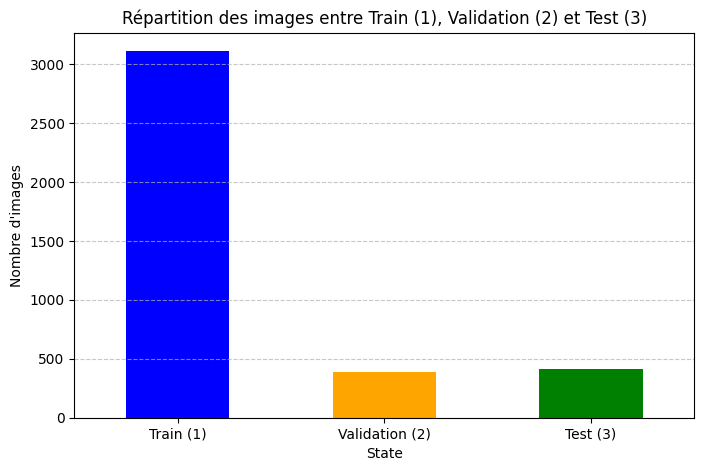

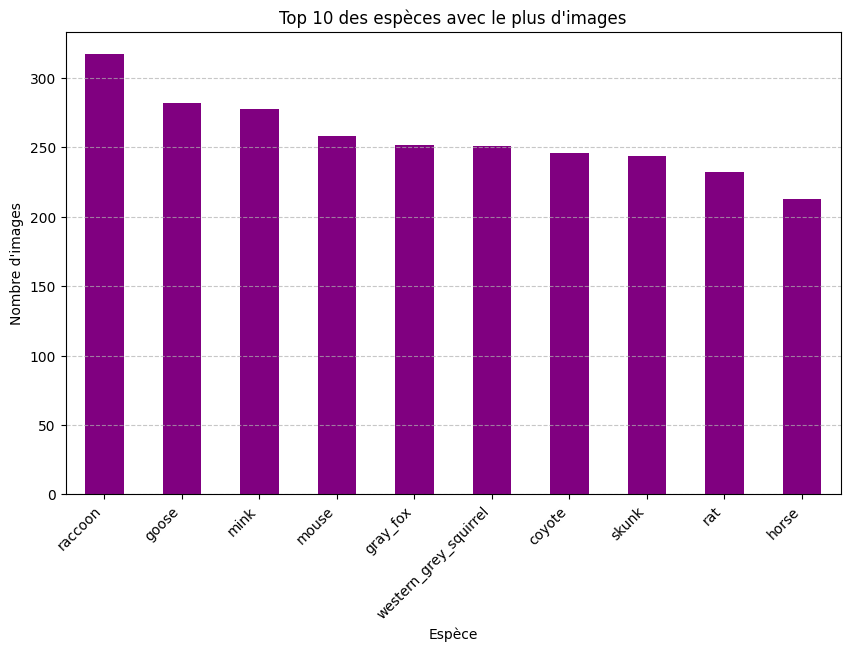

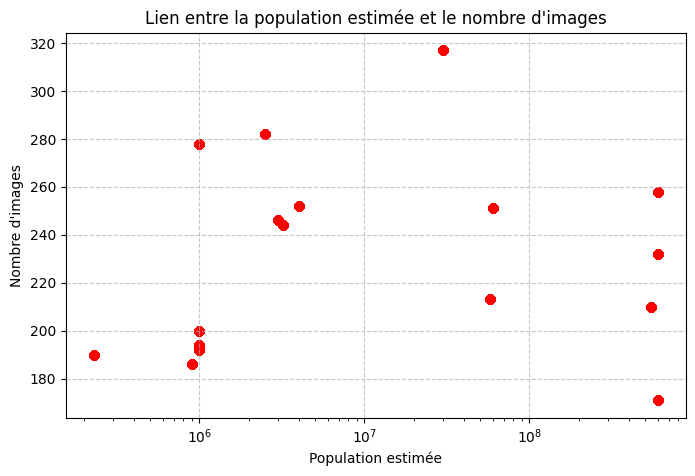

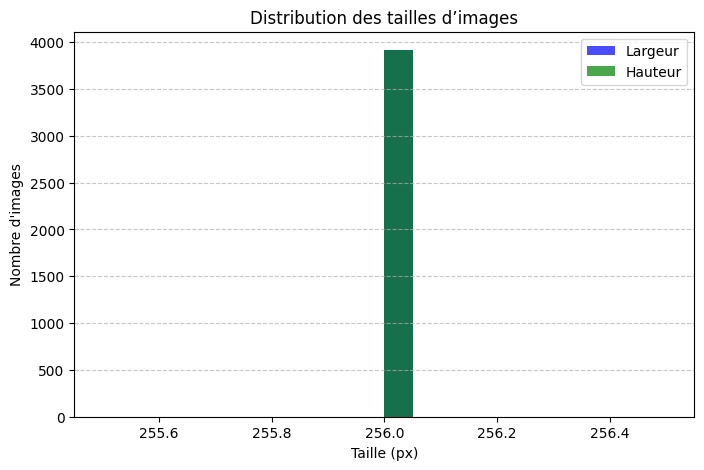

In [203]:
df_final.printSchema()
df_final.show(10)
print(f"Nombre total d'images : {df_final.count()}")
print(f"Colonnes : {df_final.columns}")

df_pandas = df_final.toPandas()

# Compter les occurrences des états (1 = train, 2 = val, 3 = test)
state_counts = df_pandas["state"].value_counts().sort_index()

# 📊 Création du graphique
plt.figure(figsize=(8, 5))
state_counts.plot(kind='bar', color=['blue', 'orange', 'green'])

plt.xlabel("State")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images entre Train (1), Validation (2) et Test (3)")
plt.xticks(ticks=[0, 1, 2], labels=["Train (1)", "Validation (2)", "Test (3)"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

# Compter le nombre d'images par espèce
species_counts = df_pandas["Espèce anglais"].value_counts().head(10)  # Top 10

# 📊 Création du graphique
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar', color='purple')

plt.xlabel("Espèce")
plt.ylabel("Nombre d'images")
plt.title("Top 10 des espèces avec le plus d'images")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(df_pandas["Population estimée"], df_pandas["Nombre d'images"], alpha=0.5, color='red')

plt.xlabel("Population estimée")
plt.ylabel("Nombre d'images")
plt.title("Lien entre la population estimée et le nombre d'images")
plt.xscale("log")  # Pour une meilleure visibilité
plt.grid(True, linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

In [185]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, monotonically_increasing_id, lit
import os
import base64

# 📌 Configuration de Spark avec JDBC MySQL
db_url = "jdbc:mysql://mysql-container:3306/wildlens?serverTimezone=UTC"
db_properties = {
    "user": "root",
    "password": "root",
    "driver": "com.mysql.cj.jdbc.Driver"
}

spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", "ETL/installation/mysql-connector-j-9.1.0.zip") \
    .getOrCreate()

# 📌 Chargement des métadonnées avec Spark
species_info_path = "data/csv/metadata.csv"
df_species = spark.read.option("header", True).option("sep", ",").csv(species_info_path)

# 📌 Nettoyage des localisations (gestion des zones)
df_species = df_species.withColumn("Localisation", split(col("Localisation"), ", "))

# 📌 Extraire les zones uniques
zones = df_species.selectExpr("explode(Localisation) as localisation").distinct()
zones = zones.withColumn("id_zone", monotonically_increasing_id())

# 📌 Insérer les zones dans `wildlens_d2_zone`
zones.write.jdbc(url=db_url, table="wildlens_d2_zone", mode="append", properties=db_properties)

# 📌 Récupération des ID des zones
zones_dict = {row["localisation"]: row["id_zone"] for row in zones.collect()}

# 📌 Associer chaque espèce à sa zone principale
def get_zone_id(localisation):
    return zones_dict.get(localisation[0], None) if localisation else None

get_zone_id_udf = spark.udf.register("get_zone_id", get_zone_id)
df_species = df_species.withColumn("id_zone", get_zone_id_udf(col("Localisation")))

# 📌 Sélection et insertion des espèces dans `wildlens_d3_especes`
df_species_filtered = df_species.select(
    col("Espèce").alias("espece"),
    col("Famille").alias("famille"),
    col("Nom latin").alias("nom_latin"),
    col("id_zone")
)

df_species_filtered.write.jdbc(url=db_url, table="wildlens_d3_especes", mode="append", properties=db_properties)

# 📌 Récupération des ID des espèces
species_df = spark.read.jdbc(url=db_url, table="wildlens_d3_especes", properties=db_properties)
species_dict = {row["espece"]: row["id_espece"] for row in species_df.collect()}

# 📌 Chargement des images et conversion en base64 pour MySQL
base_path = "data/OpenAnimalTracks/image"
image_data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        if img_file.lower().endswith(("png", "jpg", "jpeg")):
            try:
                with open(img_path, "rb") as image_file:
                    encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
                image_data.append((encoded_image,))
            except Exception as e:
                print(f"Erreur avec {img_path}: {e}")

# 📌 Création d'un DataFrame Spark avec les images
df_images = spark.createDataFrame(image_data, ["image_base64"])

# 📌 Envoi des images dans `wildlens_d1_images`
df_images.write.jdbc(url=db_url, table="wildlens_d1_images", mode="append", properties=db_properties)

# 📌 Récupération des ID des images
image_df = spark.read.jdbc(url=db_url, table="wildlens_d1_images", properties=db_properties)
image_ids = image_df.select("id_image").rdd.flatMap(lambda x: x).collect()

# 📌 Création de `wildlens_facts`
facts_data = []
for index, row in df_species.collect():
    espece = row["Espèce"]
    id_espece = species_dict.get(espece)
    id_image = image_ids[index] if index < len(image_ids) else None
    facts_data.append((id_espece, id_image, row["Description"], row["Population estimée"]))

df_facts = spark.createDataFrame(facts_data, ["id_espece", "id_image", "description", "population_estimee"])

# 📌 Insertion dans `wildlens_facts`
df_facts.write.jdbc(url=db_url, table="wildlens_facts", mode="append", properties=db_properties)

print("✅ Données insérées avec succès via Spark !")


25/03/05 20:21:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/03/05 20:21:04 INFO InMemoryFileIndex: It took 1 ms to list leaf files for 1 paths.
25/03/05 20:21:04 INFO InMemoryFileIndex: It took 1 ms to list leaf files for 1 paths.
25/03/05 20:21:04 INFO FileSourceStrategy: Pushed Filters: 
25/03/05 20:21:04 INFO FileSourceStrategy: Post-Scan Filters: (length(trim(value#500, None)) > 0)
25/03/05 20:21:04 INFO MemoryStore: Block broadcast_36 stored as values in memory (estimated size 200.2 KiB, free 433.7 MiB)
25/03/05 20:21:04 INFO MemoryStore: Block broadcast_36_piece0 stored as bytes in memory (estimated size 34.6 KiB, free 433.7 MiB)
25/03/05 20:21:04 INFO BlockManagerInfo: Added broadcast_36_piece0 in memory on 172.20.100.137:43229 (size: 34.6 KiB, free: 434.3 MiB)
25/03/05 20:21:04 INFO SparkContext: Created broadcast 36 from csv at NativeMethodAccessorImpl.java:0
25/03/05 20:21:04 INFO FileSourceScanExec: Planning scan

Py4JJavaError: An error occurred while calling o1553.jdbc.
: java.lang.ClassNotFoundException: com.mysql.cj.jdbc.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:593)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:526)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:103)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:254)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:258)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:47)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:251)
	at org.apache.spark.sql.DataFrameWriter.jdbc(DataFrameWriter.scala:766)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)


In [ ]:
# 🔄 Fonction corrigée pour éviter le shadowing et enlever le "Nombre d'images"
def get_image_info_extended(folder_path):
    if not os.path.exists(folder_path):
        return None, None, 0, 0

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    widths_list, heights_list, sizes_kb_list, total_pixels_list = [], [], [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                img_width, img_height = img.size
                file_size_kb = os.path.getsize(img_path) / 1024
                widths_list.append(img_width)
                heights_list.append(img_height)
                sizes_kb_list.append(file_size_kb)
                total_pixels_list.append(img_width * img_height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_img_width = sum(widths_list) / len(widths_list) if widths_list else None
    avg_img_height = sum(heights_list) / len(heights_list) if heights_list else None
    avg_size_kb = sum(sizes_kb_list) / len(sizes_kb_list) if sizes_kb_list else None
    avg_total_pixels = sum(total_pixels_list) / len(total_pixels_list) if total_pixels_list else None

    return avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels

# 📊 Stockage des données étendues sans "Nombre d'images"
image_data_extended = []

for folder in df_all_animals["Nom du dossier"]:
    folder_path_raw = os.path.join(image, folder)
    avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels = get_image_info_extended(folder_path_raw)
    image_data_extended.append([folder, avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels])

# 🔗 Création DataFrame mis à jour
df_extended = pd.DataFrame(image_data_extended, columns=["Nom du dossier", "Largeur Moyenne", "Hauteur Moyenne", "Poids Moyen (Ko)", "Taille Moyenne (Pixels)"])

# 👁️‍🗨️ Affichage du DataFrame
display(df_extended)

# 📊 Nouveau graphique avec axe secondaire (sans Nombre d'images)
fig, ax1 = plt.subplots(figsize=(14,7))

x_labels = df_extended["Nom du dossier"]
x_range = range(len(x_labels))

# 📏 Axe principal pour Poids et Dimensions
ax1.bar([x + 0.15 for x in x_range], df_extended["Poids Moyen (Ko)"], width=0.15, label="Poids Moyen (Ko)", color='green')
ax1.bar([x + 0.3 for x in x_range], df_extended["Largeur Moyenne"], width=0.15, label="Largeur Moyenne", color='purple')
ax1.bar([x + 0.45 for x in x_range], df_extended["Hauteur Moyenne"], width=0.15, label="Hauteur Moyenne", color='orange')

ax1.set_xlabel("Nom du dossier")
ax1.set_ylabel("Valeurs Moyennes")
ax1.set_xticks([x + 0.225 for x in x_range])
ax1.set_xticklabels(x_labels, rotation=45)

# 📊 Axe secondaire pour la Taille Moyenne (Pixels)
ax2 = ax1.twinx()
ax2.bar([x + 0.6 for x in x_range], df_extended["Taille Moyenne (Pixels)"], width=0.15, label="Taille Moyenne (Pixels)", color='red', alpha=0.5)
ax2.set_ylabel("Taille Moyenne (Pixels)")

# 🔖 Combinaison des légendes des deux axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.title("Comparaison des caractéristiques des images par dossier")
plt.tight_layout()
plt.show()
